# **Lung-PET-CT-Dx | A Large-Scale CT and PET/CT Dataset**

In [ ]:
import kagglehub
path = kagglehub.dataset_download("abdullahikabiru/lung-pet-ct-dx")
path

100%|██████████| 968M/968M [00:49<00:00, 20.5MB/s]

Extracting files...


'/root/.cache/kagglehub/datasets/abdullahikabiru/lung-pet-ct-dx/versions/1'

In [ ]:
import os
import cv2
import numpy as np
import tensorflow as tf
import random
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils import class_weight
import itertools
import warnings
warnings.filterwarnings("ignore",category=FutureWarning)
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, classification_report, confusion_matrix
import cv2
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

# **Loading DataSet**

In [ ]:
image_files = []
for root, _, files in os.walk('/root/.cache/kagglehub/datasets/abdullahikabiru/lung-pet-ct-dx/versions/1'):
    for file in files:
        if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif', '.tiff')):
            image_files.append(os.path.join(root, file))

def extract_class_name(filepath):
    class_name = filepath.split("/")[-2]
    return class_name

In [ ]:
os.makedirs('/content/drive/MyDrive/Data', exist_ok=True)

image_files = random.sample(image_files, len(image_files))
df = pd.DataFrame({'image_path': image_files})
df['class'] = df['image_path'].apply(extract_class_name)
df.to_csv('/content/drive/MyDrive/Data/image_files.csv', index=False)

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Data/image_files.csv')
midpoint = len(df) // 2

# Read the first half of the image files
first_half_image_files = df['image_path'][:midpoint].tolist()
len(first_half_image_files)


6747

SEGMENTATION

In [ ]:
class_labels = []
image_data = []

def extract_class_name(filepath):
    class_name = filepath.split("/")[-2]
    return class_name

def segment_lung(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 100, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if contours:
        mask = np.zeros_like(gray)
        cv2.drawContours(mask, contours, -1, 255, thickness=cv2.FILLED)
        segmented = cv2.bitwise_and(image, image, mask=mask)
        return segmented
    return image

def load_images(image_paths):
  images = []
  for image_path in image_paths:
    try:
        image = cv2.imread(image_path)
        image = cv2.resize(image, (224, 224))
        if image is not None:
          images.append(image)
          class_labels.append(extract_class_name(image_path))
    except Exception as e:
        print(f"Error loading image {image_path}: {e}")

  return images

loaded_images = load_images(first_half_image_files)
print(f"Loaded {len(loaded_images)} images.")
class_labels = np.array(class_labels)
image_data = np.array(loaded_images)

Loaded 6747 images.


In [ ]:
image_data.shape, class_labels.shape

((6747, 224, 224, 3), (6747,))

# **Preprocessing**

In [ ]:
# One-hot encode the class labels
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()
class_labels = lb.fit_transform(class_labels)

from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(image_data, class_labels, test_size=0.15, random_state=42)


# Create data generators

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow(X_train, y_train, batch_size=32)
validation_generator = val_datagen.flow(X_val, y_val, batch_size=32)

In [ ]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((5734, 224, 224, 3), (5734, 3), (1013, 224, 224, 3), (1013, 3))

# **Class weights**

In [ ]:
class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                                 classes=np.unique(np.argmax(y_train, axis=1)),
                                                 y=np.argmax(y_train, axis=1))
class_weights = dict(enumerate(class_weights))
class_weights

{0: 0.4477239009916452, 1: 6.1260683760683765, 2: 1.6577045388840705}

# **Data Visualization**

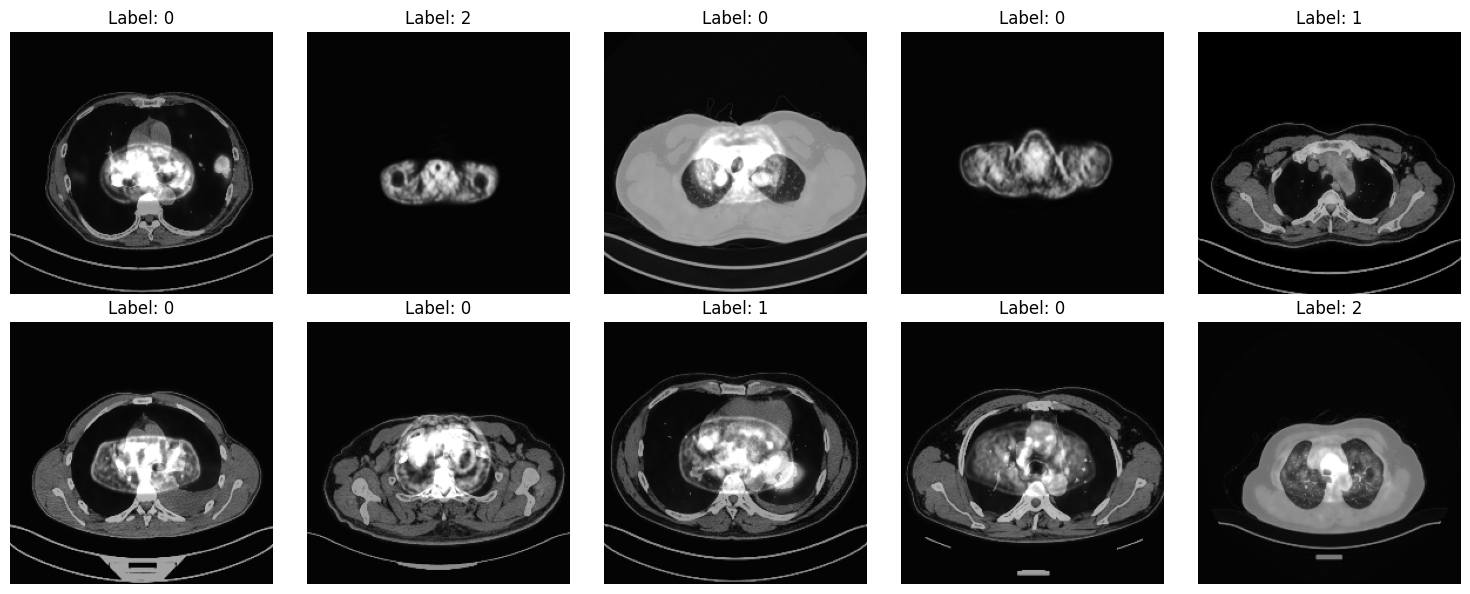

In [ ]:
images, labels = next(train_generator)

# Display the images with their labels
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.ravel()

for i in range(10):
    axes[i].imshow(images[i])
    axes[i].set_title(f"Label: {np.argmax(labels[i])}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()

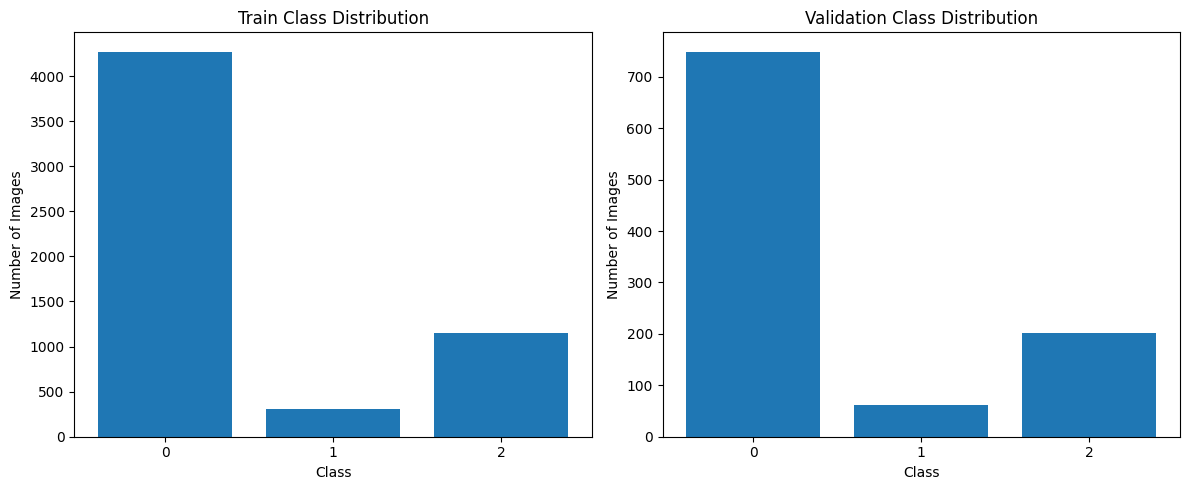

In [ ]:
def plot_class_distribution(generator, title):
    class_counts = {}
    for i in range(len(generator)):
        _, labels = next(generator)
        for label in labels:
            class_index = np.argmax(label)
            class_counts[class_index] = class_counts.get(class_index, 0) + 1

    classes = sorted(class_counts.keys())
    counts = [class_counts[cls] for cls in classes]

    plt.bar(classes, counts)
    plt.xlabel("Class")
    plt.ylabel("Number of Images")
    plt.title(title)
    plt.xticks(classes)


plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plot_class_distribution(train_generator, "Train Class Distribution")

plt.subplot(1, 2, 2)
plot_class_distribution(validation_generator, "Validation Class Distribution")


plt.tight_layout()
plt.show()

# **Model Training**

In [ ]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(3, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)
for layer in base_model.layers[-30:]:
    layer.trainable = True

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 26,212,227 (99.99 MB)

 Trainable params: 26,159,107 (99.79 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [ ]:
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [ ]:
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs= 50,
    callbacks=[early_stopping]
)

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


180/180 ━━━━━━━━━━━━━━━━━━━━ 151s 479ms/step - accuracy: 0.6920 - loss: 0.9644 - val_accuracy: 0.7394 - val_loss: 0.7309
Epoch 2/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 81s 296ms/step - accuracy: 0.7514 - loss: 0.6680 - val_accuracy: 0.7394 - val_loss: 0.7210
Epoch 3/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 53s 295ms/step - accuracy: 0.7452 - loss: 0.6384 - val_accuracy: 0.7394 - val_loss: 0.7222
Epoch 4/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 54s 298ms/step - accuracy: 0.7599 - loss: 0.6138 - val_accuracy: 0.7394 - val_loss: 1.2055
Epoch 5/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 54s 298ms/step - accuracy: 0.7818 - loss: 0.5740 - val_accuracy: 0.7433 - val_loss: 0.7713
Epoch 6/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 54s 299ms/step - accuracy: 0.8035 - loss: 0.5038 - val_accuracy: 0.7897 - val_loss: 0.5325
Epoch 7/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 56s 312ms/step - accuracy: 0.8200 - loss: 0.4616 - val_accuracy: 0.3692 - val_loss: 4.9786
Epoch 8/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 54s 300ms/step - accuracy: 0.8460 - loss: 0.4017 - va

In [ ]:
import os

# Define the directory path
model_dir = '/content/drive/MyDrive/Models'

# Create the directory if it doesn't exist
os.makedirs(model_dir, exist_ok=True)

model.save('/content/drive/MyDrive/Models/my_model.keras') # Adding the .keras extension

# **Model Evaluation**

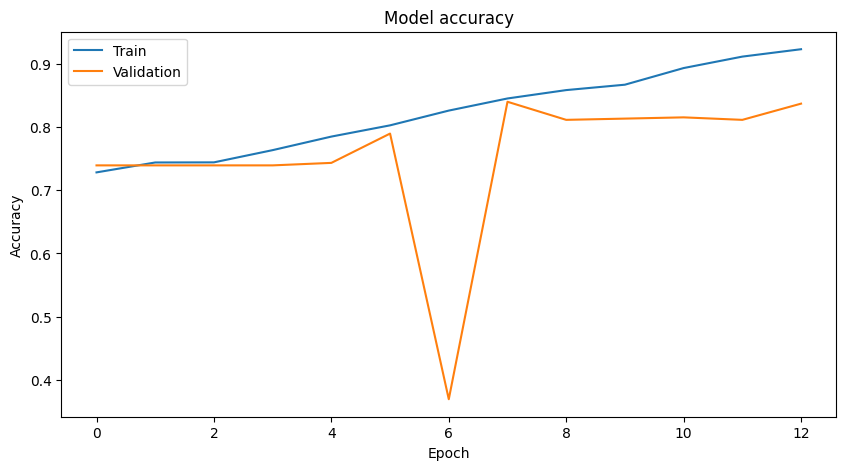

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()